# Import the libraries

>Determines best portfolio allocation between BTC ETH ETC LTC DASH NEO ZEC XMR 

>Uses sharpe ratio, finds low volatility with high returns. Designed to be ran Monthly

>Author: Samuel L. Peoples

>Version date: 20171210

>Latest run date: 20180110

In [12]:
from urllib.request import urlopen
import matplotlib.pyplot as plt
% matplotlib inline
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import datetime
import re
import os

# Build Crypto List Function

>This function builds the individual lists for the three months,

>For BTC ETH ETC LTC DASH NEO ZEC, XMR the function will pull Time, High price (USD), Low price (USD), Open Price (USD)  Close price (USD), Volume From, Volume To, and the Percent Returns

>It will then save the data to [name]CurrencyHLOC.csv

In [3]:
def buildCrpytoList(html, name):
    list = []
    htmlOpen = urlopen(html)
    htmlSoup = BeautifulSoup(htmlOpen, 'html.parser')
    htmlRows = str(htmlSoup).split('[')
    del(htmlRows[0])
    del(htmlRows[0])
    del(htmlRows[0])
    for i in range(htmlRows.__len__()-1):
        htmlRows[i] = str(htmlRows[i]).split(']')[0]
    htmlRows[htmlRows.__len__()-1] = str(
        htmlRows[htmlRows.__len__()-1]).split(']')[0]
    for row in htmlRows:
        if row == '':
            break
        items = row.split(",")
        
        returns = returnVal(float(items[1]),float(items[4]))
        entry = {
            "Time":timeFix(items[0]), 
            name+"Close":items[4], 
            name+"High":items[2], 
            name+"Low":items[3], 
            name+"Open":items[1], 
            name+"Volume":items[5], 
            name+"Returns":str(returns)}
        list.append(entry)
    df = pd.DataFrame(list)
    df.reindex(columns = ["Time",name+"High", name+"Low", 
                          name+"Open",name+"Close", name+"Volume", 
                          name+"Returns"]).to_csv(name+"CurrencyHLOC.csv", 
                                                  header ={"Time","High", 
                                                           "Low", "Open",
                                                           "Close", "Volume"})
    return df


# Helper Functions

>This function converts timestamps to place legible timestamps in the dataset

In [4]:
def timeFix(timestamp):
    return(datetime.datetime.fromtimestamp(
        int(timestamp)).strftime('%Y-%m-%d %H:%M:%S'))

> This function bypasses divZero errors.

In [5]:
def returnVal(num, den):
    if den <=0:
        return 0
    else:
        diff = den-num
        return diff/num

# Build Master List Function

>This fucntion builds the master list by merging all currency lists by date.

>It will then save the data to MasterCurrencyHLOC.csv

In [7]:
def buildMaster(coins, coinsNames, backTesting):
    masterList = []
    for i in range(8):
        masterList.append(buildCrpytoList(coins[i], coinsNames[i]))
    masterDF = masterList[0].merge(masterList[1], left_on = "Time",
                                   right_on = 'Time', how= 'outer').merge(
        masterList[2], left_on = "Time", right_on = 'Time', how= 'outer').merge(
        masterList[3], left_on = "Time", right_on = 'Time', how= 'outer').merge(
        masterList[4], left_on = "Time", right_on = 'Time', how= 'outer').merge(
        masterList[5], left_on = "Time", right_on = 'Time', how= 'outer').merge(
        masterList[6], left_on = "Time", right_on = 'Time', how= 'outer').merge(
        masterList[7], left_on = "Time", right_on = 'Time', how= 'outer')
    masterDF.reindex(columns = [
        "Time",
        coinsNames[0]+"High",coinsNames[0]+"Low",coinsNames[0]
        +"Open",coinsNames[0]+"Close",coinsNames[0]+"Volume",coinsNames[0]+"Returns",
        coinsNames[1]+"High",coinsNames[1]+"Low",coinsNames[1]
        +"Open",coinsNames[1]+"Close",coinsNames[1]+"Volume",coinsNames[1]+"Returns",
        coinsNames[2]+"High",coinsNames[2]+"Low",coinsNames[2]
        +"Open",coinsNames[2]+"Close",coinsNames[2]+"Volume",coinsNames[2]+"Returns",
        coinsNames[3]+"High",coinsNames[3]+"Low",coinsNames[3]
        +"Open",coinsNames[3]+"Close",coinsNames[3]+"Volume",coinsNames[3]+"Returns",
        coinsNames[4]+"High",coinsNames[4]+"Low",coinsNames[4]
        +"Open",coinsNames[4]+"Close",coinsNames[4]+"Volume",coinsNames[4]+"Returns",
        coinsNames[5]+"High",coinsNames[5]+"Low",coinsNames[5]
        +"Open",coinsNames[5]+"Close",coinsNames[5]+"Volume",coinsNames[5]+"Returns",
        coinsNames[6]+"High",coinsNames[6]+"Low",coinsNames[6]
        +"Open",coinsNames[6]+"Close",coinsNames[6]+"Volume",coinsNames[6]+"Returns",
        coinsNames[7]+"High",coinsNames[7]+"Low",coinsNames[7]
        +"Open",coinsNames[7]+"Close",coinsNames[7]+"Volume",coinsNames[7]+"Returns",]
        ).to_csv(
            "MasterCurrencyHLOC.csv", header ={"Time","High", 
                                               "Low", "Open", "Close","Volume"})
    
    return masterList

# Calculate and populate returns

>This function builds the list of percent returns, prints the percent returns for today and average percent returns for the three months. 

>It will then save the data to returns.csv

In [8]:
def buildReturns():
    data = pd.read_csv('MasterCurrencyHLOC.csv')
    data.set_index('Time',inplace=True)
    returns = data.drop(data.columns[[0,1,2,3,4,5,7,8,9,10,
                                      11,13,14,15,16,17,19,
                                      20,21,22,23,25,26,27,
                                      28,29,31,32,33,34,35,
                                      37,38,39,40,41,43,44,
                                      45,46,47]],axis =1)
    returns.to_csv("returns.csv")
    print ("Percent Returns on Closure:")
    print(returns.ix[-1])
    print()
    print("Average Percent Returns on Closure:")
    print(returns.mean())
    return returns

# Optimization

>This function will develop 50,000 randomized portfolios, and find the portfolio with the highest sharpe ratio. (https://www.investopedia.com/terms/s/sharperatio.asp)

>It then saves the results to sharpeRatios50kResults.csv and passes them to be plotted.

In [9]:
def optimize(masterList, returns):
    mean_returns = returns.mean()
    matCov = returns.cov()
    coins = ["btc", "eth", "etc", "ltc", "dash", "neo", "zec", "xmr"]
    port = 50000
    results = np.zeros((4 + len(coins)-1, port))
    for i in range(port):
        weights = np.array(np.random.random(8))
        weights /= np.sum(weights)
        port_return = np.sum(mean_returns*weights)*1140
        port_stdv = np.sqrt(np.dot(weights.T,np.dot(matCov, weights)))*np.sqrt(1140)
        #Returns based on this portfolio
        results[0,i] = port_return
        #standard deviation based on this portfolio
        results[1,i] = port_stdv
        #Variance of this portfolio
        results[2,i] = results[0,i]/ (results[1,i])
        
        #3: BTC
        #4: ETH
        #5: ETC
        #6: LTC
        #7: DASH
        #8: NEO
        #9: ZEC
        #10: XMR
        for j in range(len(weights)):
            results[j+3,i]= weights[j]
    pd.DataFrame(results).to_csv("sharpeRatios50kResults.csv")
    plotResults(results)

# Plot the results

>This function will develop the scatterplot of 50,000 portfolios, x = Volatility, y = Returns

>It then saves the figure to sharpeRatios50k.png.

>The function will then print the suggested portfolio allocation, and save the contents to recommendedPortfolio.csv

In [10]:
def plotResults(results):
    heat = results[0]/(results[2])
    scatter = []
    for i in range(50000):
        scatter.append([str(results[2][i]), 
                           str(results[0][i]),
                           "BTC: "+str(results[3][i]),
                            "ETH: "+str(results[4][i]),
                            "ETC: "+str(results[5][i]),
                            "LTC: "+str(results[6][i]),
                            "DASH: "+str(results[7][i]),
                            "NEO: "+str(results[8][i]),
                            "ZEC: "+str(results[9][i]),
                            "XMR: "+str(results[10][i])])
        if results[0][i]/results[2][i] == max(heat):
            maxX = results[2][i]
            maxY = (results[0][i])
            recommendedPortfolio = [
            "Recommended Portfolio Distribution:",
            "BTC: "+str(results[3][i]),
            "ETH: "+str(results[4][i]),
            "ETC: "+str(results[5][i]),
            "LTC: "+str(results[6][i]),
            "DASH: "+str(results[7][i]),
            "NEO: "+str(results[8][i]),
            "ZEC: "+str(results[9][i]),
            "XMR: "+str(results[10][i])]
    plt.scatter(x = results[2], y = results[0], c=[str(point/255) for point in heat])
    plt.scatter(x = maxX, y = maxY, c = 200, s = 75, alpha = .2)
    plt.title('50,000 Portfolios, Sharpe Ratio')
    plt.xlabel('Volatility')
    plt.ylabel('Returns')
    plt.savefig("sharpeRatios50k.png")
    print()
    for line in recommendedPortfolio:
        print(line)
    pd.DataFrame(scatter).to_csv("scatterPoints.csv")
    pd.DataFrame(recommendedPortfolio).to_csv("recommendedPortfolio.csv")
    plt.show()

# Go Wild

> Define the api locations and let her rip

Percent Returns on Closure:
btcReturns    -0.013504
ethReturns    -0.030195
etcReturns    -0.049800
ltcReturns    -0.031777
dashReturns   -0.035785
neoReturns    -0.046518
zecReturns    -0.069189
xmrReturns    -0.036899
Name: 2018-01-11 00:00:00, dtype: float64

Average Percent Returns on Closure:
btcReturns     0.002251
ethReturns     0.002921
etcReturns     0.002924
ltcReturns     0.003391
dashReturns    0.002838
neoReturns     0.003489
zecReturns     0.002657
xmrReturns     0.003389
dtype: float64


C:\Users\Ripti\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if sys.path[0] == '':



Recommended Portfolio Distribution:
BTC: 0.0021076267919
ETH: 0.0893510945295
ETC: 0.287048272754
LTC: 0.0406171784081
DASH: 0.000358525253673
NEO: 0.450344662471
ZEC: 0.129367477968
XMR: 0.000805161823629


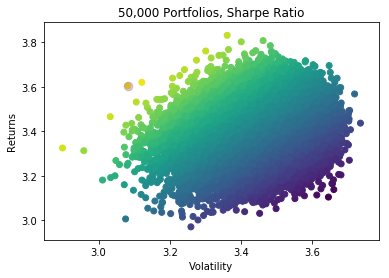

In [11]:
backTesting = True
path = re.split(" ",str(datetime.datetime.today()))[0]
if not os.path.exists(path):
    os.makedirs(path)
os.chdir(path)
btc = "https://api.cryptowat.ch/markets/bitfinex/btcusd/ohlc"
eth = "https://api.cryptowat.ch/markets/bitfinex/ethusd/ohlc"
etc = "https://api.cryptowat.ch/markets/bitfinex/etcusd/ohlc"
ltc = "https://api.cryptowat.ch/markets/bitfinex/ltcusd/ohlc"
dash ="https://api.cryptowat.ch/markets/bitfinex/dashusd/ohlc"
neo = "https://api.cryptowat.ch/markets/bitfinex/neousd/ohlc"
zec = "https://api.cryptowat.ch/markets/bitfinex/zecusd/ohlc"
xmr = "https://api.cryptowat.ch/markets/bitfinex/xmrusd/ohlc"
coins = [btc, eth, etc, ltc, dash, neo, zec, xmr]
coinsNames = ["btc", "eth", "etc", "ltc", "dash", "neo", "zec", "xmr"]
masterList = buildMaster(coins, coinsNames, backTesting) 
optimize(masterList, buildReturns())